In [1]:
import pandas as pd
import os
import sys
import numpy as np
import ast
import geopandas as gpd
import re
import math
import copy

from urllib.request import urlopen
from zipfile import ZipFile

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

import requests
from io import StringIO
from shapely.geometry import Point

from matplotlib_scalebar.scalebar import ScaleBar


import matplotlib as mpl
import glob

import glob
import seaborn as sb
sb.set(style='whitegrid', palette='pastel', color_codes=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE + 4)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE + 4)  # fontsize of the figure title


pd.set_option('display.max_columns', 0)  # show all columns
pd.options.display.max_colwidth = 100

In [2]:
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    # print("wt.sum:", wt.sum())
    return (val * wt).sum() / wt.sum() 

In [3]:
# save_dir = r'P:\Shared drives\T5\safegraph_bias\figures'
# data_dir = r'P:\Shared drives\T5\safegraph_bias'


data_dir = r'P:\Shared drives\T5\safegraph_bias\refined_20230309'
save_dir = r'P:\Shared drives\T5\safegraph_bias\refined_20230309\figures'
# monthly_files = glob.glob(os.path.join(data_dir, r'sampling_rates_*_monthly.csv'))


urban_rural_county_xls = os.path.join(data_dir, 'ruralurbancodes2013.xls')
urban_rural_county_df = pd.read_excel(urban_rural_county_xls, dtype={'FIPS':str})
# add the urban column
urban_rural_county_df['Urban'] = urban_rural_county_df['Description'].str[:5].replace({'Metro': 'Yes', 'Nonme': 'No'})


urban_rural_tract_csv = os.path.join(data_dir, 'FoodAccessResearchAtlasData2019.csv')
urban_rural_tract_df = pd.read_csv(urban_rural_tract_csv, dtype={'fips':str}, encoding='UTF-8')
# clean data
urban_rural_tract_df['FIPS'] = urban_rural_tract_df['fips'].astype(str).str.zfill(11)
urban_rural_tract_df['Urban'] = urban_rural_tract_df['Urban'].replace({1:'Yes', 0:'No'})

urban_rural_cbg_csv = os.path.join(data_dir, 'CBG_urbanization_2type_2019.csv')
urban_rural_cbg_df = pd.read_csv(urban_rural_cbg_csv, dtype={'CBG_FIPS':str})
urban_rural_cbg_df['FIPS'] = urban_rural_cbg_df['CBG_FIPS'] 

# store in a dict
urban_df_dict = {'county':urban_rural_county_df, 'tract':urban_rural_tract_df, 'CBG':urban_rural_cbg_df}


years = [2022, 2019, 2018, 2020, 2021]
levels = ['state', 'county']
data_dict = {}

for year in years:
    df_list = []
    for level in levels:
        csv_file = os.path.join(data_dir, f'monthly_bias_{level}_{year}_time.csv')
        print(csv_file)
        try:
            df = pd.read_csv(csv_file, dtype={'state_fips':str},  engine='c', encoding='utf8') # ,
        except:
            df = pd.read_csv(csv_file, dtype={'state_fips':str},  engine='c', encoding='utf16') # ,

        df['fips_level'] = level # pd.to_datetime(df['start_date'], format='%Y%m')
        # df['county_FIPS'] = df['fips'].str[:5]
        df_list.append(df)
    
    df = pd.concat(df_list).fillna("0")
    df['county_FIPS'] = df['county_fips'].astype(int).astype(str).str.zfill(5)
    
    df['FIPS'] = df['state_fips'] 
    mask_idx = (df['fips_level'] == 'county')
    
    df.loc[mask_idx, 'FIPS'] = df[mask_idx]['county_FIPS'] 
    # df['bias_value'] = df['bias'].astype(float) - 1
    data_dict[year] = df

data_dict[2022]

P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_state_2022_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_county_2022_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_state_2019_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_county_2019_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_state_2018_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_county_2018_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_state_2020_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_county_2020_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_state_2021_time.csv
P:\Shared drives\T5\safegraph_bias\refined_20230309\monthly_bias_county_2021_time.csv


,date_range_start,state_fips,variable,start_date,census_ratio,safegraph_ratio,CBG_count,device_count,populaion,safegraph_ratio_to_census,bias,fips_level,county_fips,county_FIPS,FIPS
0,202201,01,Female,202201,0.516106,0.517215,3431,287208.579631,2.516173e+06,1.002148,0.002148,state,0,00000,01
1,202201,01,Male,202201,0.483894,0.482785,3431,268089.420369,2.359126e+06,0.997709,-0.002291,state,0,00000,01
2,202201,01,<15,202201,0.145877,0.143533,3431,79703.465805,7.111930e+05,0.983932,-0.016068,state,0,00000,01
3,202201,01,15–17,202201,0.035232,0.034817,3431,19333.887510,1.717650e+05,0.988234,-0.011766,state,0,00000,01
4,202201,01,18–24,202201,0.059505,0.059248,3431,32900.307725,2.901040e+05,0.995684,-0.004316,state,0,00000,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927355,202212,72,<20K,202212,0.489055,0.471454,27,247.042108,1.696582e+04,0.96401,-0.03599,county,72153.0,72153,72153
927356,202212,72,20K–30K,202212,0.150658,0.164367,27,86.128475,5.226471e+03,1.090997,0.090997,county,72153.0,72153,72153
927357,202212,72,30K–50K,202212,0.153281,0.164135,27,86.006988,5.317477e+03,1.070813,0.070813,county,72153.0,72153,72153
927358,202212,72,50K–100K,202212,0.092326,0.102520,27,53.720702,3.202867e+03,1.110423,0.110423,county,72153.0,72153,72153


In [4]:
CBG_popu_df_dict = {}

annual_pop_dict = {}
for year in [2018, 2019]:
    csv_file = os.path.join(data_dir, f'cbg_acs_{year}_county_tract.csv')
    print("Loading:", year)
    pop_df = pd.read_csv(csv_file)
    pop_df['state_fips'] = pop_df['state_fips'].astype(str).str.zfill(2)
    pop_df['county_fips'] = pop_df['county_fips'].astype(str).str.zfill(5)
    pop_df['tract_fips'] = pop_df['tract_fips'].astype(str).str.zfill(11)
    pop_df['cbg_fips'] = pop_df['fips'].astype(str).str.zfill(12)
    pop_df['FIPS'] = pop_df['cbg_fips']
    
    annual_pop_dict[year] = {}
    annual_pop_dict[year]['CBG'] = pop_df
    
    county_pop_df = pop_df.groupby(['state_fips', 'county_fips', 'state'], as_index=False).sum(numeric_only=True)
    county_pop_df['FIPS'] = county_pop_df['county_fips']
    annual_pop_dict[year]['county'] = county_pop_df
    
    state_pop_df = pop_df.groupby(['state_fips',  'state'], as_index=False).sum(numeric_only=True)
    state_pop_df['FIPS'] = state_pop_df['state_fips']  
    annual_pop_dict[year]['state'] = state_pop_df

annual_pop_dict[2020] = annual_pop_dict[2019]
annual_pop_dict[2021] = annual_pop_dict[2019]
annual_pop_dict[2022] = annual_pop_dict[2019]


print("Verification: annual population")
print('year, state, county, CBG:')
for year, pop_dict in annual_pop_dict.items():
    print(year, pop_dict['state']['totalpopulation'].sum(), 
          pop_dict['county']['totalpopulation'].sum(), 
          pop_dict['CBG']['totalpopulation'].sum())

Loading: 2018
Loading: 2019
Verification: annual population
year, state, county, CBG:
2018 326228729 326228729 326228729
2019 327939105 327939105 327939105
2020 327939105 327939105 327939105
2021 327939105 327939105 327939105
2022 327939105 327939105 327939105


In [113]:
# labels



level, year: state 2022
level, year: state 2019
level, year: state 2018
level, year: state 2020
level, year: state 2021
max, min: 0.06320449304125117 -0.04710172697890219
level, year: county 2022
level, year: county 2019
level, year: county 2018
level, year: county 2020
level, year: county 2021
max, min: 0.06912353601594472 -0.04971080915162152


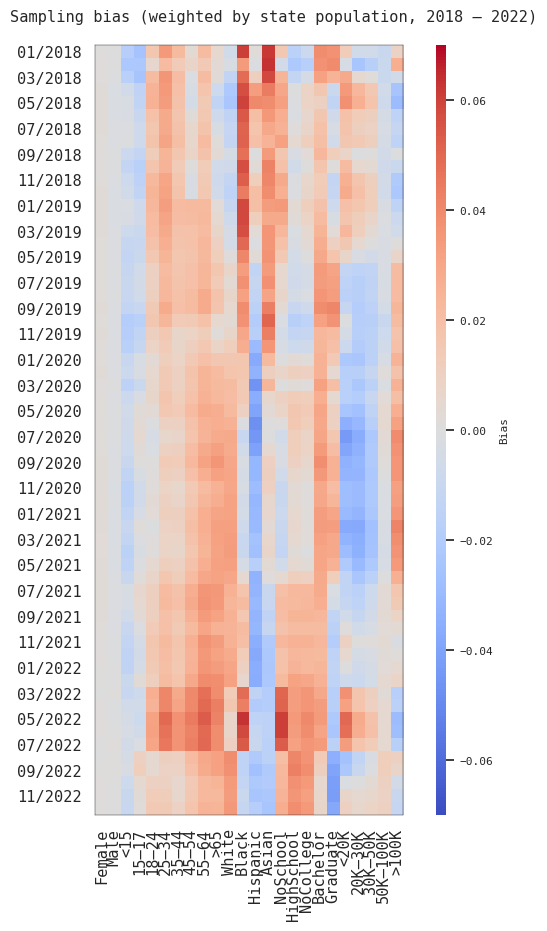

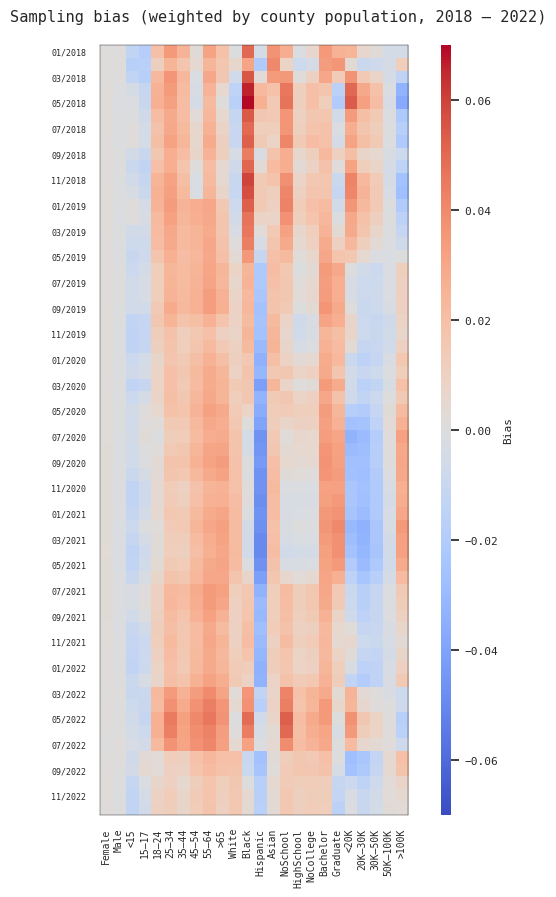

In [5]:
import matplotlib.dates as mdates
pd.set_option('mode.chained_assignment', None)

value_max =  0.07
value_min = -0.07

columns = ['Female', 'Male', '<15', '15–17', '18–24', '25–34', '35–44',
       '45–54', '55–64', '>65', 'White', 'Black', 'Hispanic', 'Asian',
       'NoSchool', 'HighSchool', 'NoCollege', 'Bachelor', 'Graduate',
       '<20K', '20K–30K', '30K–50K', '50K–100K', '>100K']

years = [2022, 2019, 2018, 2020, 2021]

plt.rcParams['font.family'] = 'monospace'  

for level in levels: 
    # all_df = pd.concat([df for year, df in data_dict.items()])
    # all_df['bias'] = all_df['bias'].astype(float)
    df_list = []
    for year in years:
        print("level, year:", level, year)
        
        df = data_dict[year].query(f" fips_level == '{level}' ")
        df['date_range_start'] = df['date_range_start'].astype(str)
        df['date_range_start'] = pd.to_datetime(df['date_range_start'], format='%Y%M')
        df['date_range_start'] = df['date_range_start'].dt.strftime('%M/%Y')
        # df['date_range_start'] = pd.to_datetime(df['date_range_start'], format='%M/%Y')
        # df['date_range_start'] = df['date_range_start'].dt.strftime('%m/%Y')
        pop_df = annual_pop_dict[year][level]        
        data_dict[year]['bias'] = data_dict[year]['bias'].astype(float)
        df = data_dict[year].query(f" fips_level == '{level}' ")
        merged_df = df.merge(pop_df, left_on="FIPS", right_on='FIPS')
        
        df_list.append(merged_df)
        
    all_df = pd.concat(df_list)    

    # clean data
    CLEAN_DATA = True
    if CLEAN_DATA:
        all_df = all_df.query(f" bias <  bias.quantile(.975)")
        all_df = all_df.query(f" bias >  bias.quantile(.025)")
     
    heat_arr = all_df.query(f" fips_level == '{level}' ").groupby(['date_range_start', 'variable']).apply(weighted_average, 'bias', 'totalpopulation').unstack(level=1) # .apply(weighted_average, 'bias', 'bias').unstack(level=1)
    heat_arr = heat_arr[columns]
    heat_np = heat_arr.to_numpy()
    
    print("max, min:", heat_np.max(), heat_np.min())

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
    # plt.rc('font', size=12)          # controls default text sizes
    plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
    


    cmap = 'coolwarm'
    im = ax.imshow(heat_np, cmap=cmap, vmax=value_max, vmin=value_min)
    
        # Format tick labels to be MM/YYYY
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    
    ax.grid(False)
    ax.set_xticks(np.arange(len(heat_arr.columns)))
    ax.set_xticklabels(labels=list(heat_arr.columns), rotation=90,)
    

    
    labels = pd.to_datetime(heat_arr.index, format='%Y%M').strftime("%M/%Y").to_list()
    ax.set_yticks(np.arange(0, len(heat_arr.index), 2), 
                 labels=labels[::2])
    # # ax.set_yticklabels(labels=list(heat_arr.index[::2]))
    # ax.set_yticks(labels=list(heat_arr.index))
  
    # Set ticks to be every two months
    # ax.yaxis.set_major_locator(mdates.MonthLocator(interval=2))
 

    ax.set_title(f"Sampling bias (weighted by {level} population, 2018 – 2022)", y=1.02, x=0.58, fontsize=11)
 
    cax = fig.add_axes([0.7, 0.11, 0.01, 0.77])   # tuple (left, bottom, width, height)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
    # sm._A = []
    clb = plt.colorbar(sm, cax=cax, label="")
    clb.ax.set_ylabel('Bias',fontsize=8)
    clb.ax.tick_params(labelsize=8) 
    for spine in clb.ax.spines.values():
        spine.set_color("none")
    for spine in ax.spines.values():
        spine.set_color("k")
        spine.set_linewidth(0.3)
    
    new_name = os.path.join(save_dir, f'Heat_map_{level}_all_years_weighted.png')
    plt.savefig(new_name, dpi=300)



In [100]:
labels

0        01/2021
1        01/2021
2        01/2021
3        01/2021
4        01/2021
          ...   
14971    12/2021
14972    12/2021
14973    12/2021
14974    12/2021
14975    12/2021
Name: date_range_start, Length: 14976, dtype: object

0        01/2021
1        01/2021
2        01/2021
3        01/2021
4        01/2021
          ...   
14971    12/2021
14972    12/2021
14973    12/2021
14974    12/2021
14975    12/2021
Name: date_range_start, Length: 14976, dtype: object

In [65]:
df['date_range_start'] = pd.to_datetime(df['date_range_start'], format='%Y%M')
df['date_range_start']

C:\Users\N\AppData\Local\Temp\ipykernel_24396\1918842080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_range_start'] = pd.to_datetime(df['date_range_start'], format='%Y%M')


0       2021-01-01 00:01:00
1       2021-01-01 00:01:00
2       2021-01-01 00:01:00
3       2021-01-01 00:01:00
4       2021-01-01 00:01:00
                ...        
14971   2021-01-01 00:12:00
14972   2021-01-01 00:12:00
14973   2021-01-01 00:12:00
14974   2021-01-01 00:12:00
14975   2021-01-01 00:12:00
Name: date_range_start, Length: 14976, dtype: datetime64[ns]